# Beyond the Bias-Variance Trade-Off: Making Sense of Double Descent

This notebook is a companion to the blog post ["Double Descent Demystified: Rethinking Model Complexity in Machine Learning"](). It includes the code used to create all the figures shown there.

To explore it, you can either run it locally (refer to the [README]("./README.md") for setup instructions) or launch it in Google Colab: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/garyuppal/blog-code/blob/main/double_descent_overview/main.ipynb?fresh=true)

## Setup

In [52]:
# Check if running in Google Colab and install dependencies
# If running locally, this will just print a message
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Installing dependencies from requirements.txt...")
    !pip install -r https://raw.githubusercontent.com/garyuppal/blog-code/refs/heads/main/double_descent_overview/requirements.txt
else:
    print("Running locally...")

Running locally...


In [53]:
# load the necessary libraries
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path
import matplotlib as mpl
from matplotlib.colors import ListedColormap, Normalize, TwoSlopeNorm
import matplotlib.pyplot as plt


In [54]:
# change font to arial for figures
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['svg.fonttype'] = 'none'

In [55]:
# set random seed for reproducibility
np.random.seed(42)

In [56]:
# Create output directory if it doesn't exist
outpath = Path("output")
outpath.mkdir(parents=True, exist_ok=True)

## Generate synthetic data

In [57]:
# Function to generate data
def data_func(x):
    return 5*x + 10*np.cos(15.0*x)

In [58]:
# Generate synthetic data
n_data = 40

x = np.sort(np.random.rand(n_data))
eps = np.random.normal(loc=0,scale=1,size=x.shape)
y = data_func(x)
data = y + eps

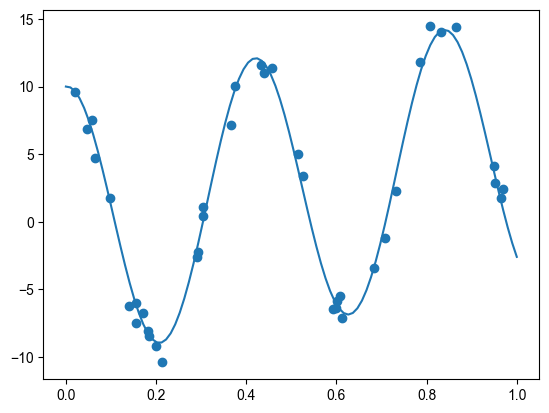

In [59]:
# visualize the data
fig, ax = plt.subplots()
xplot = np.linspace(0, 1, 100)
yplot = data_func(xplot)
ax.plot(xplot,yplot)
ax.scatter(x,data)

## Split data into test and train sets

In [60]:
# Split the data into training and testing sets
# Use 80% of the data for training and 20% for testing
x_train, x_test, y_train, y_test = train_test_split(x, data, test_size=0.2, random_state=10)

/tmp/ipykernel_4587/1855886261.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)
/tmp/ipykernel_4587/1855886261.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=fontsize)


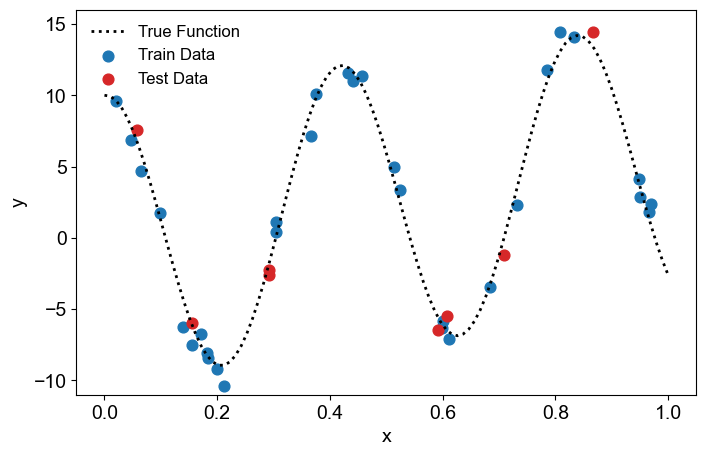

In [61]:
# Plot the training and testing data, save the figure
fontsize = 14
lgd_fontsize = 12
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(xplot,yplot,':', label='True Function', color='black', linewidth=2)
ax.scatter(x_train, y_train, s=60, color='tab:blue', label='Train Data')
ax.scatter(x_test, y_test, s=60, color='tab:red', label='Test Data')
ax.set_xlabel('x', fontsize=fontsize)
ax.set_ylabel('y', fontsize=fontsize)
ax.set_ylim(-11, 16)
ax.legend(fontsize=lgd_fontsize, frameon=False)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=fontsize)
plt.savefig(outpath / "data_plot.svg", bbox_inches='tight')

<!-- # Fit with Legendre polynomials -->

## Fit data with Legendre polynomial basis

In [62]:
from numpy.polynomial.legendre import Legendre

In [63]:
def fit_legendre(x,y,P, ridge_lambda=None):
    # Normalize x to [-1, 1] because Legendre polynomials are defined on that interval
    x = np.asarray(x)
    x_min, x_max = x.min(), x.max()
    x_scaled = 2 * (x - x_min) / (x_max - x_min) - 1
    # Build the design matrix with Legendre basis
    X_design = np.vstack([Legendre.basis(p)(x_scaled) for p in range(P)]).T
    n = len(x)
    if ridge_lambda is not None:
            A = X_design.T @ X_design + ridge_lambda * np.eye(P)
            b = X_design.T @ y
            beta = np.linalg.solve(A, b) 
    else:
        if P < n: # Under-parameterized case
            beta = np.linalg.solve(X_design.T @ X_design, X_design.T @ y)
        else: # Over-parameterized case
            beta =  X_design.T @ np.linalg.solve(X_design @ X_design.T, y)
    return beta, X_design, (x_min, x_max)

## Plot test and train errors versus model size

In [64]:
# Function to calculate Root Mean Square Error (RMSE)
def rmse(a,b):
    return np.sqrt(np.mean((a-b)**2))

In [65]:
# Function to get training and testing errors
# This function fits a Legendre polynomial to the training data and computes the RMSE for both training and testing sets.
# It returns the errors, the fitted coefficients (beta), the design matrix for the training data, and the min/max of the x values used for normalization.
def get_train_test_errors(xTrain, yTrain, xTest, yTest,P, ridge_lambda=None):
    beta, X_design, (x_min, x_max) = fit_legendre(xTrain,yTrain,P,ridge_lambda=ridge_lambda)

    x_train_scaled = 2*(xTrain - x_min)/(x_max - x_min) - 1
    x_test_scaled = 2*(xTest - x_min)/(x_max - x_min) - 1

    X_design_train = np.vstack([Legendre.basis(p)(x_train_scaled) for p in range(P)]).T
    X_design_test = np.vstack([Legendre.basis(p)(x_test_scaled) for p in range(P)]).T

    y_pred_train = X_design_train @ beta
    y_pred_test = X_design_test @ beta

    err_train = rmse(yTrain, y_pred_train)
    err_test = rmse(yTest, y_pred_test)
    return err_train, err_test, beta, X_design, (x_min, x_max)

In [66]:
# Function to compute the effective number of parameters
# Computes the effective number of parameters based on a variance based measure defined in the paper:
"""Curth, A., Jeffares, A., & van der Schaar, M. (2023). A u-turn on double descent: 
Rethinking parameter counting in statistical learning. Advances in Neural Information 
Processing Systems, 36, 55932-55962."""

def compute_effective_num_params(x_train, x_test, beta, xmin, xmax):
    P = len(beta)

    X_train_design = np.vstack([Legendre.basis(p)(2 * (x_train - xmin) / (xmax - xmin) - 1) for p in range(P)]).T # NxP
    X_test_design = np.vstack([Legendre.basis(p)(2 * (x_test - xmin) / (xmax - xmin) - 1) for p in range(P)]).T # MxP

    n_train = len(x_train)
    n_test = len(x_test)

    if P < n_train:
        # Under-parameterized case
        beta_hat = np.linalg.pinv(X_train_design.T @ X_train_design) @ X_train_design.T # PxN
    else:
        # Over-parameterized case
        beta_hat = X_train_design.T @ np.linalg.pinv(X_train_design @ X_train_design.T) # PxN
    # print(X_train_design.shape, X_test_design.shape, beta_hat.shape)
    S_hat_train = X_train_design @ beta_hat
    S_hat_test = X_test_design @ beta_hat

    # Compute effective number of parameters
    p_eff_train = np.trace(S_hat_train @ S_hat_train.T)
    p_eff_test = np.trace(S_hat_test @ S_hat_test.T) *(n_train / n_test)
    return p_eff_train, p_eff_test

In [67]:
# Function to get training and testing errors versus model size
def get_errors_vs_model_size(xTrain, yTrain, xTest, yTest, P_list, ridge_lambda=None):
    train_errors = np.zeros(len(P_list))
    test_errors = np.zeros(len(P_list))
    betas = []
    X_designs = []
    x_mins = []
    x_maxs = []
    pe_trains = []
    pe_tests = []
    # Loop over each polynomial degree in P_list
    for i,p in enumerate(P_list):
        err_train, err_test, beta, X_design, (x_min, x_max) = get_train_test_errors(xTrain, yTrain, xTest, yTest, p, ridge_lambda)
        train_errors[i] = err_train
        test_errors[i] = err_test
        betas.append(beta)
        X_designs.append(X_design)
        x_mins.append(x_min)
        x_maxs.append(x_max)
        pe_train, pe_test = compute_effective_num_params(xTrain, xTest, beta, x_min, x_max)
        pe_trains.append(pe_train)
        pe_tests.append(pe_test)
    return train_errors, test_errors, betas, X_designs, x_mins, x_maxs, pe_trains, pe_tests

In [68]:
# Set the range of polynomial degrees to test 
P_list = np.arange(1,201,1)
train_errors, test_errors, betas, X_designs, x_mins, x_maxs, pe_trains, pe_tests = get_errors_vs_model_size(x_train, y_train, x_test, y_test, P_list)

/tmp/ipykernel_4587/3145364130.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)
/tmp/ipykernel_4587/3145364130.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=fontsize)


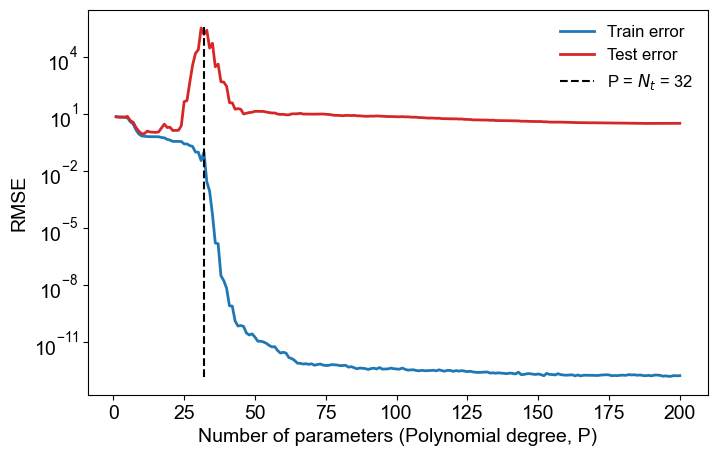

In [69]:
# Plot train and test errors versus model size
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(P_list, train_errors, color='tab:blue', label='Train error', linewidth=2)
ax.plot(P_list, test_errors, color='tab:red', label='Test error', linewidth=2)
ax.vlines(x=len(x_train), ymin=0.9*np.amin(train_errors), ymax=1.1*np.amax(test_errors), color='black', 
          linestyle='--', label=rf'P = $N_t$ = {len(x_train)}')
ax.set_xlabel('Number of parameters (Polynomial degree, P)', fontsize=fontsize)
ax.set_ylabel('RMSE', fontsize=fontsize)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=fontsize)
ax.legend(fontsize=lgd_fontsize, frameon=False)
ax.set_yscale('log')
# plt.savefig(outpath / "errors_vs_model_size.svg", bbox_inches='tight')

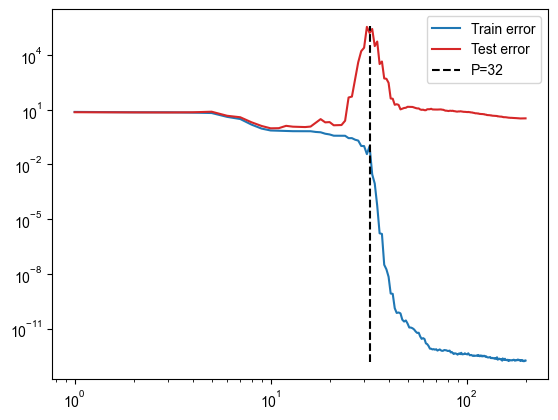

In [70]:
fig, ax = plt.subplots()
ax.plot(P_list, train_errors, color='tab:blue', label='Train error')
ax.plot(P_list, test_errors, color='tab:red', label='Test error')
ax.vlines(x=len(x_train), ymin=0.9*np.amin(train_errors), ymax=1.1*np.amax(test_errors), color='black', linestyle='--', label=f'P={len(x_train)}')
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')

In [71]:
# get the index of the minimum test error case
min_idx = np.argmax(test_errors == np.amin(test_errors))

In [72]:
# check
print(min_idx)
print(np.amin(test_errors))
print(test_errors[min_idx])

9
0.9518950919735925
0.9518950919735925


## Plot losses with some example fits

In [74]:
def plot_fit(ax, x_train, y_train, x_test, y_test, beta, xmin, xmax):
    P = len(beta)
    # Predict on new data
    x_plot = np.sort(np.concatenate([np.linspace(xmin, xmax, 2000), x_train, x_test]))
    x_plot_scaled = 2 * (x_plot - xmin) / (xmax - xmin) - 1
    X_plot_design = np.vstack([Legendre.basis(p)(x_plot_scaled) for p in range(P)]).T
    y_pred = X_plot_design @ beta

    ax.scatter(x_train, y_train, label="Train data", s=60, color='tab:blue')
    ax.scatter(x_test, y_test, label="Test data", s=60, color='tab:red')
    ax.plot(x_plot, y_pred, color='black', label=f"Model fit", linewidth=0.5)
    ax.legend()
    return ax

In [75]:
# idxs = [5-1, min_idx, len(x_train)-1, 150-1]
# for idx in idxs:
#     fig, ax = plt.subplots(figsize=(5, 5))
#     ax=plot_fit(ax, x_train, y_train, x_test, y_test, betas[idx], x_mins[idx], x_maxs[idx])
#     ax.set_ylim(-15,20)
#     ax.legend(fontsize=lgd_fontsize, frameon=False)
#     ax.set_xlabel('x', fontsize=fontsize)
#     ax.set_ylabel('y', fontsize=fontsize)
#     ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)
#     ax.set_yticklabels(ax.get_yticklabels(), fontsize=fontsize)
#     if idx == min_idx:
#         ax.set_title(f"Legendre Polynomial Fit (P={P_list[idx]}) (Best Test Error)", fontsize=fontsize)
#     elif idx == len(x_train)-1:
#         ax.set_title(f"Legendre Polynomial Fit (P={P_list[idx]}) (Interpolation threshold)", fontsize=fontsize)
#     else:
#         ax.set_title(f"Legendre Polynomial Fit (P={P_list[idx]})", fontsize=fontsize)
#     plt.savefig(outpath / f"fit_at_{idx}.svg", bbox_inches='tight') 

In [76]:
from matplotlib.gridspec import GridSpec

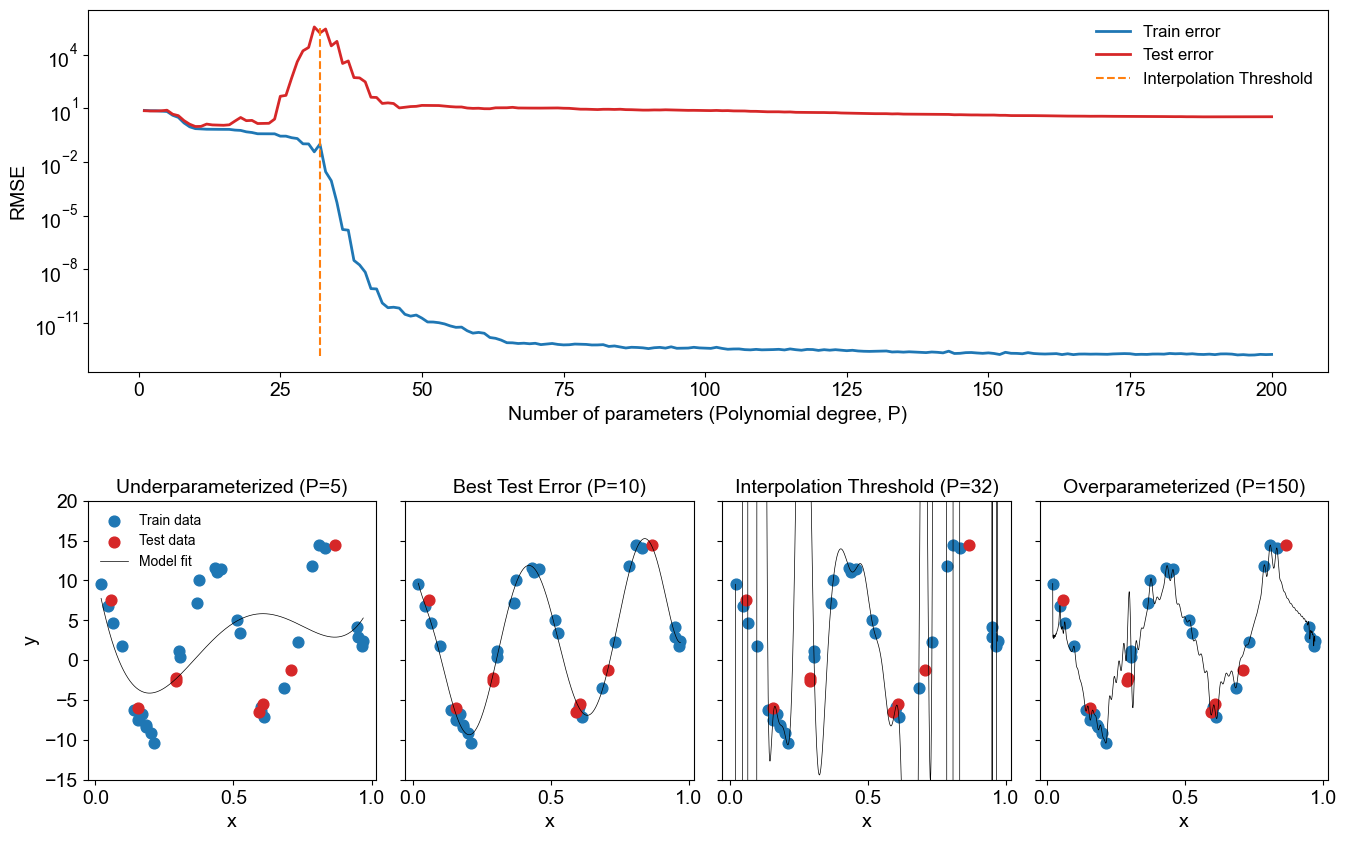

In [78]:

# Create a figure and a 2-row GridSpec
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(nrows=2, ncols=4, height_ratios=[1.3, 1], wspace=0.1, hspace=0.4)  # Top row taller

# ==== Top plot: RMSE vs model size ====
ax0 = fig.add_subplot(gs[0, :])  # Top row, spans all 4 columns
ax0.plot(P_list, train_errors, color='tab:blue', label='Train error', linewidth=2)
ax0.plot(P_list, test_errors, color='tab:red', label='Test error', linewidth=2)
ax0.vlines(x=len(x_train), ymin=0.9*np.amin(train_errors), ymax=1.1*np.amax(test_errors), 
           color='tab:orange', linestyle='--', label='Interpolation Threshold')

ax0.set_xlabel('Number of parameters (Polynomial degree, P)', fontsize=fontsize)
ax0.set_ylabel('RMSE', fontsize=fontsize)
ax0.set_yscale('log')
ax0.tick_params(labelsize=fontsize)
ax0.legend(fontsize=lgd_fontsize, frameon=False)

# ==== Bottom row: example fits ====
idxs = [5-1, min_idx, len(x_train)-1, 150-1]
ttls = ["Underparameterized", "Best Test Error", "Interpolation Threshold", "Overparameterized"]
ttls = [ttls[i] + f" (P={P_list[idxs[i]]})" for i in range(len(idxs))]  # Add Param value to titles
axs = []
for i in range(len(idxs)):
    axs.append(fig.add_subplot(gs[1, i]))  # One subplot per column

for i in range(1,len(axs)):
    axs[i].sharey(axs[0])  # Share y-axis with the first subplot

for i, idx in enumerate(idxs):
    axs[i] = plot_fit(axs[i], x_train, y_train, x_test, y_test, betas[idx], x_mins[idx], x_maxs[idx])
    axs[i].set_ylim(-15, 20)
    axs[i].set_xlabel('x', fontsize=fontsize)
    axs[i].tick_params(labelsize=fontsize)
    axs[i].legend(fontsize=lgd_fontsize, frameon=False)
    axs[i].set_title(ttls[i], fontsize=fontsize)
    if i > 0:
        axs[i].tick_params(labelleft=False)
        axs[i].get_legend().remove()  # Remove legend from all but the first subplot
    else:
        axs[i].set_ylabel('y', fontsize=fontsize)
        axs[i].legend(fontsize=10, frameon=False, loc='upper left')

# ==== Save combined figure ====
plt.savefig(outpath / "model_error_vs_num_params_with_examples.svg", bbox_inches='tight')

## Plot test error vs effective number of parameters
Effective number of parameters are computed based on a variance based measure defined in the paper: 
`Curth, A., Jeffares, A., & van der Schaar, M. (2023). A u-turn on double descent: 
Rethinking parameter counting in statistical learning. Advances in Neural Information 
Processing Systems, 36, 55932-55962`

In [79]:
class PiecewiseNormalize(Normalize):
    def __init__(self, vmin, vmax, pmax):
        super().__init__(vmin, vmax)
        self.pmax = pmax

    def __call__(self, value, clip=None):
        value = np.clip(value, self.vmin, self.vmax)
        scale = np.where(value <= self.pmax,
                         0.5 * (value - self.vmin) / (self.pmax - self.vmin),
                         0.5 + 0.5 * (value - self.pmax) / (self.vmax - self.pmax))
        return scale

    def inverse(self, value):
        value = np.asarray(value)
        return np.where(value <= 0.5,
                        self.vmin + (value / 0.5) * (self.pmax - self.vmin),
                        self.pmax + ((value - 0.5) / 0.5) * (self.vmax - self.pmax))

In [80]:
# Custom combined colormap
colors1 = plt.get_cmap('Blues_r')(np.linspace(0.3, 1, 128))
colors2 = plt.get_cmap('Reds')(np.linspace(0.3, 1, 128))
combined_colors = np.vstack([colors1, colors2])
combined_cmap = ListedColormap(combined_colors)

# Apply
vmin, vmax = np.amin(P_list), np.amax(P_list)
pmax = len(x_train)  # This is the point where we switch from blue to red

norm = TwoSlopeNorm(vmin=vmin, vcenter=pmax, vmax=vmax)

/tmp/ipykernel_4587/3211896785.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)
/tmp/ipykernel_4587/3211896785.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=fontsize)


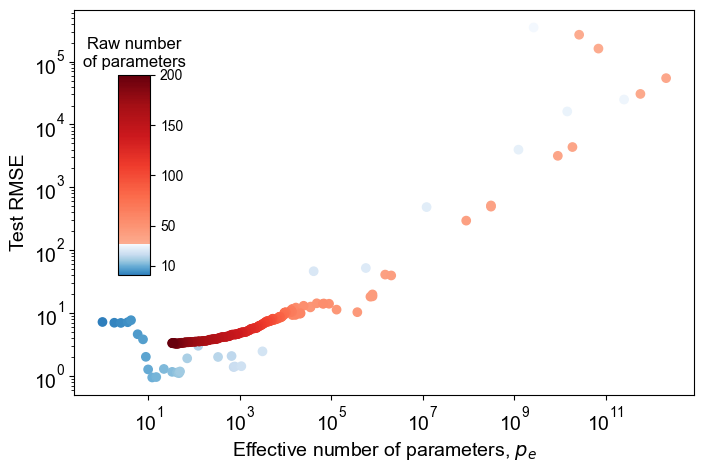

In [81]:
# Create a scatter plot of effective number of parameters vs test RMSE, save the figure
fig, ax = plt.subplots(figsize=(8, 5))
# Scatter plot with color mapping
sc = ax.scatter(pe_tests, test_errors, c=P_list, cmap=combined_cmap, norm=norm)

cax = fig.add_axes([0.18, 0.35, 0.04, 0.4])  # (left, bottom, width, height)
cb = plt.colorbar(sc, cax=cax, norm=norm)

yticks = np.arange(50,201,50)
yticks = np.append(yticks, [P_list[min_idx]])
yticks = np.sort(np.unique(yticks))  # Ensure unique yticks
cb.ax.set_yscale('linear')
cb.ax.set_yticks(yticks)
cb.ax.tick_params(labelsize=10)

cb.ax.set_title('Raw number\nof parameters', fontsize=12)
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel(r'Effective number of parameters, $p_e$', fontsize=fontsize)
ax.set_ylabel('Test RMSE', fontsize=fontsize)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=fontsize)
plt.savefig(outpath / "effective_params_vs_test_rmse.svg", bbox_inches='tight')